In [1]:
from larch.xafs import feffit, feffit_dataset, feffit_transform, feffit_report
from larch.xafs import pre_edge, autobk, xftf, xftr, ff2chi, feffpath
from larch.fitting import  param_group, param
from larch.io import h5group, read_ascii, read_athena, read_xdi, read_specfile, extract_athenagroup

import os
import copy
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

[root] WARNING : Larchs apps and shell are not supported due to missing dependencies: cannot import name 'LarchWxApp' from 'larch.wxlib' (D:\Python\Anaconda3\envs\xraylarch\lib\site-packages\larch\wxlib\__init__.py)


In [ ]:
"""
Plan

1. Organise Cu Standard scripts. (Done)
2. Larch fit data_1 of 9. (Done)
3. Organise script for data_1. (Done)
4. Simultaneous fit of data 2 - 9 w/ script. (Done)
5. Compare results with Artemis and Larch (if sigma2 optimised as constrain.) (Not important)
6. Improve fitting by rebinning either in time-axis or EXAFS region. (Didn't work so well.)
7. Improve fitting by cropping and recalibrating all 9000 spectra in DAWN (in LARCH in the future).
8. Fit all 9000 spectra.
9. Adaptive method to choose Cu-Cu and/or Cu-O.
10. Decide fitting parameters: dk, rbkg, dr, etc.
11. Fix double normalisation issue.
12. Maybe different e0, or calibrate properly.
13. Find/create suitable feff model (Hao's suggestion).
14. Improvise, Adapt, Overcome.

"""

In [2]:
""" 0. Preparing Data. """

data_dir = "data\\time_series_2"
fnames = [fname for fname in os.listdir(data_dir)]
path_list = [os.path.join(data_dir, fname) for fname in fnames]

In [3]:
""" 1. Batch Reading Data """

# Initialisation
data_list = [read_ascii(fpath, labels="null energy mu") for fpath in path_list]
for data, fname in zip(data_list, fnames):
    data.groupname = fname

# Pre-processing - EXAFS fittings only need a valid k space
    autobk(data, rbkg=1.00) # Need to have option to suppress normalisation in case loaded spectra is already normed
    xftf(data, kmin=3.0, kmax=10, dk=1.0, window="hanning", kweight=2.00)
    xftr(data, rmin=1.0, rmax=4.0, dr=1.0, window="hanning")

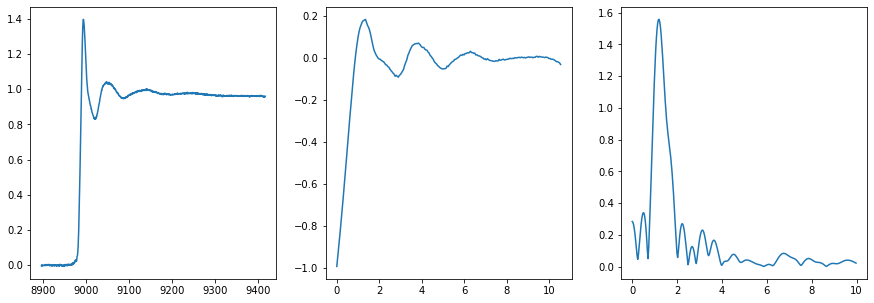

In [15]:
""" Misc: Plotting """
def plot(data_list, index):
    energy = data_list[index].energy
    mu = data_list[index].mu
    norm = data_list[index].norm
    chi = data_list[index].chi
    k = data_list[index].k
    chir_mag = data_list[index].chir_mag
    r = data_list[index].r

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].plot(energy, norm)
    ax[1].plot(k, chi)
    ax[2].plot(r, chir_mag)
    
plot(data_list, 0)

In [4]:
""" 2.1 Setup feffit - feffit parameters + FT and fitting space """

# Create feffit Parameter Group to hold fit parameters (Core parameters)
_feffit_params = param_group(s02=param(0.87348, min=0, vary=False),
                             e0=param(0.1, min=-10, max=10, vary=True),
#                              sigma2_cu=param(0.008, min=0.001, max=0.009, vary=True),
                             sigma2_o=param(0.008, min=0.001, max=0.009, vary=True))

# Create feffit Parameter Group to hold fit parameters (Repeating parameters)
data_num = len(data_list)

fit_params = ["n_cuo_", "delr_o_"]
fit_values = [param(1.0, vary=True),
              param(0.001, min=-0.5, max=0.5, vary=True)]

all_fit_params = [param + str(i) for i in range(data_num) for param in fit_params]
all_fit_values = fit_values * data_num

for key, value in zip(all_fit_params, all_fit_values):
    setattr(_feffit_params, key, value)

# Define Fourier transform and fitting space
# Actual FT parameters for EXAFS fitting
_feffit_trans = feffit_transform(kmin=3.000, kmax=10.000, dk=1.0000, kw=2,
                                 window="hanning", fitspace='r', rmin=1.000, rmax=4.000)


In [17]:
""" 2.2 Setup up paths for all datasets. """

# Create list of base paths
_paths = []

_paths_names = ["O195_"]
_all_paths_names = [pname + str(i) for i in range(data_num) for pname in _paths_names]

path_original = "C:/Users/user/larch/feff/Cu1_K_Tenorite_cif11639/feff0001.dat"
path_new = "C:/Users/user/Downloads/Cu-O_path_at_2_1500.rsp"

_path_o = feffpath(path_new,
               degen=1, e0='e0', sigma2='sigma2_o')

_path_keys = ["label", "s02", "deltar"]
_path_values_o = ["O195_", "s02 * n_cuo_", "delr_o_"]

for i in range(data_num):

    # Setup for Cu-O paths    
    _path_o_temp = copy.deepcopy(_path_o)
    for key, value in zip(_path_keys, _path_values_o):
        setattr(_path_o_temp, key, value + str(i))
        
    _paths_dict = {_paths_names[0] + str(i): _path_o_temp}
    
    _paths.append(_paths_dict)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
_pathsum = ff2chi(_paths[0], paramgroup=_feffit_params)

In [ ]:
""" 2.3 Make dict of paths, sum them using a group of parameters. """
_ff2chi_paths_list = copy.deepcopy(_paths)

for _ff2chi_paths in _ff2chi_paths_list:
    if len(_ff2chi_paths) > 0:
        _pathsum = ff2chi(_ff2chi_paths, paramgroup=_feffit_params)

In [6]:
""" 2.4 Build and Run feffit dataset"""
_feffit_dataset_list = [feffit_dataset(data=data, paths=path, transform=_feffit_trans) for data, path in zip(data_list, _paths)]
_feffit_result = feffit(_feffit_params, _feffit_dataset_list)

# _feffit_dataset = feffit_dataset(data=data, transform=_feffit_trans, paths=_ff2chi_paths)
# _feffit_result = feffit(_feffit_params, _feffit_dataset) # _feffit_dataset can be a list***

# Insert _feffit_result into self.feffit_history
# if not hasattr(data, 'feffit_history'): 
#     data.feffit_history = []    
# _feffit_result.label = 'Fit %i' % (1+len(data.feffit_history))
# data.feffit_history.insert(0, _feffit_result)

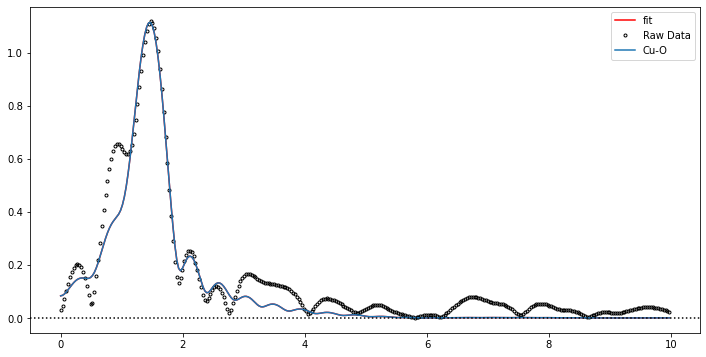

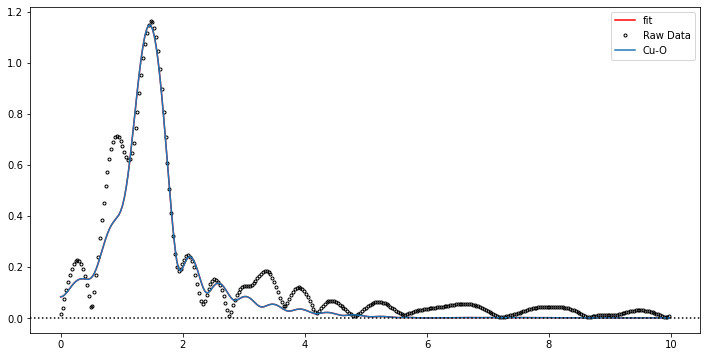

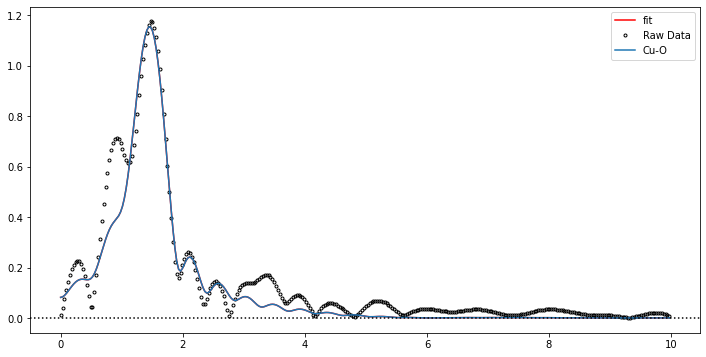

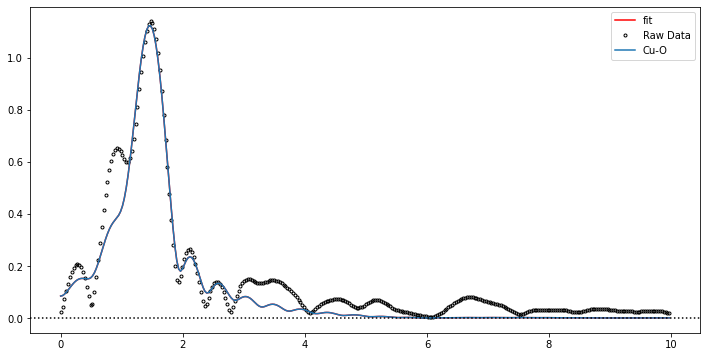

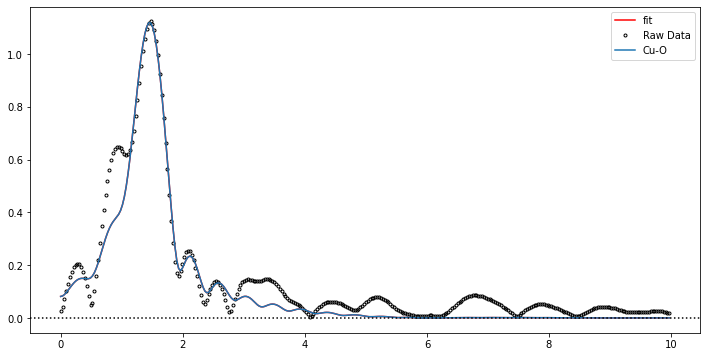

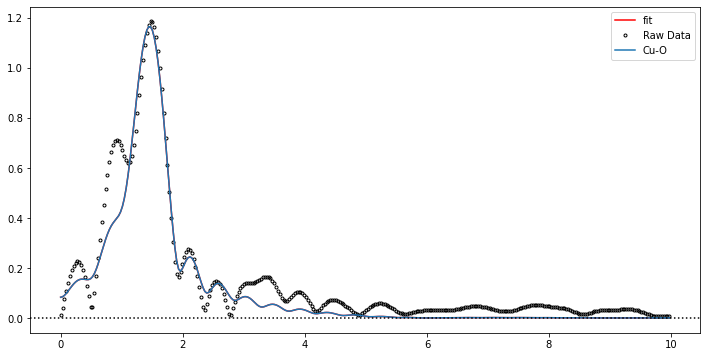

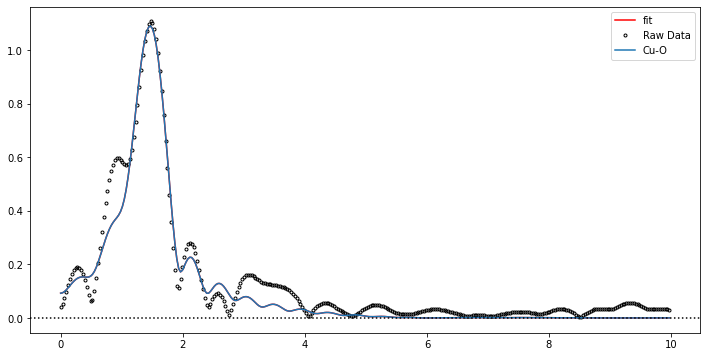

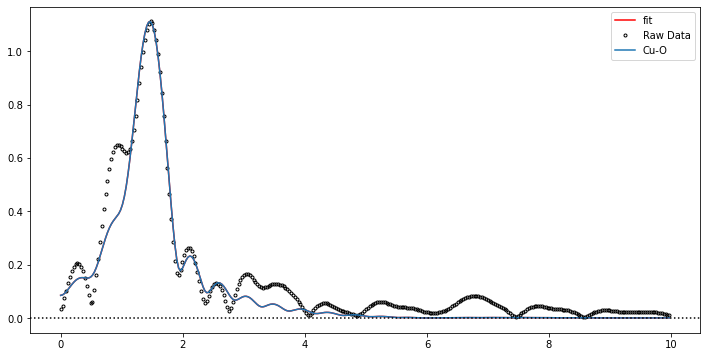

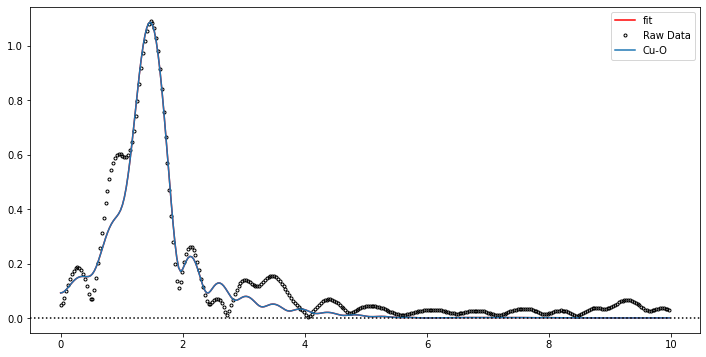

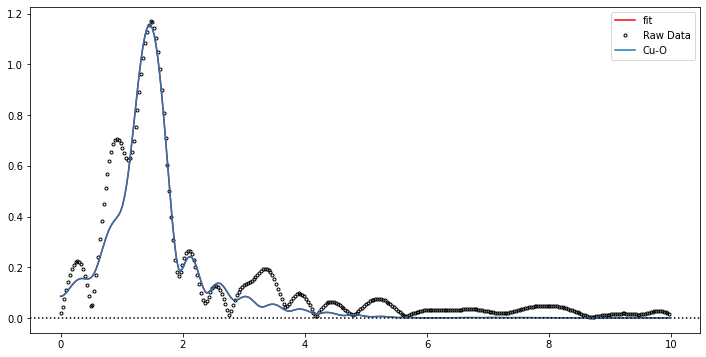

In [7]:
""" Misc: Plotting fitted results"""
for i, result in enumerate(_feffit_result.datasets):

    data_r = result.data.r
    data_chir_mag = result.data.chir_mag

    fit_r = result.model.r
    fit_chir_mag = result.model.chir_mag

#     a = result.paths["Cu256_" + str(i)].r
#     b = result.paths["Cu256_" + str(i)].chir_mag

    c = result.paths["O195_" + str(i)].r
    d = result.paths["O195_" + str(i)].chir_mag

    fig = plt.figure(figsize=(12, 6))
    plt.plot(fit_r, fit_chir_mag, color="r", label="fit")
    plt.plot(data_r, data_chir_mag, lw=0, marker='o', markersize=3, fillstyle='none', color="k", label="Raw Data")
#     plt.plot(a, b, label="Cu-Cu")
    plt.plot(c, d, label="Cu-O")
    plt.axhline(0, color="k", linestyle=":")
    plt.legend()

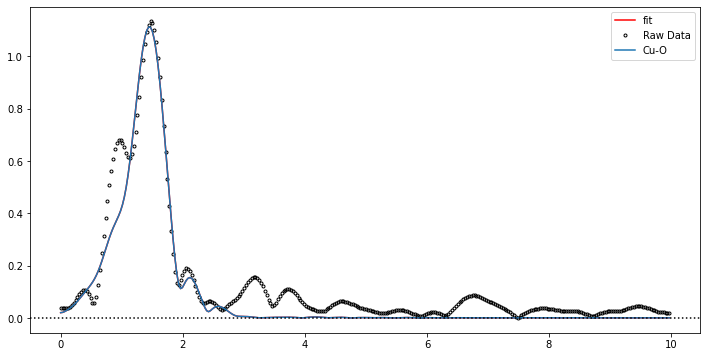

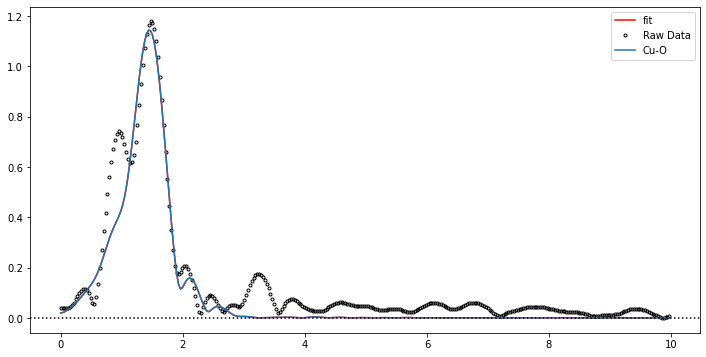

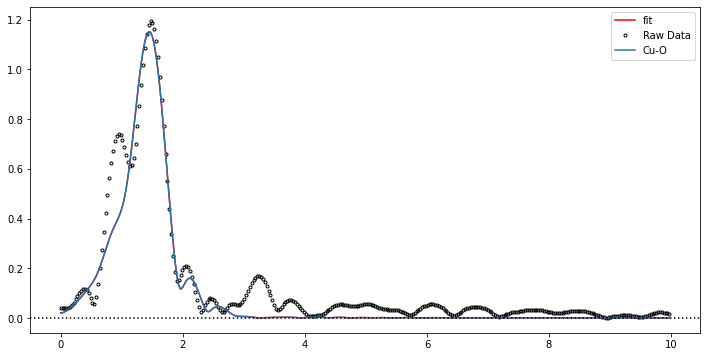

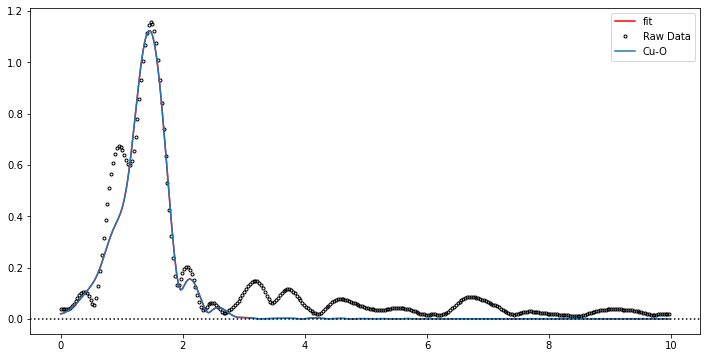

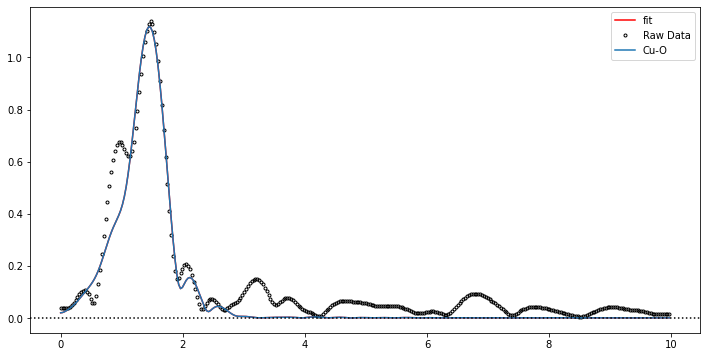

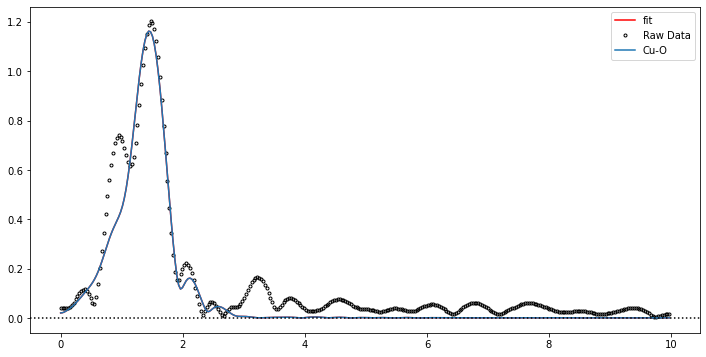

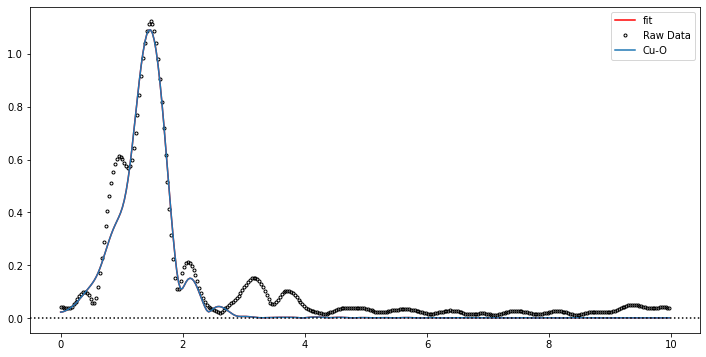

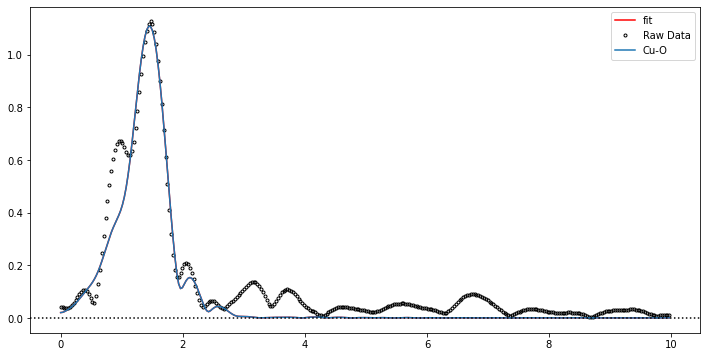

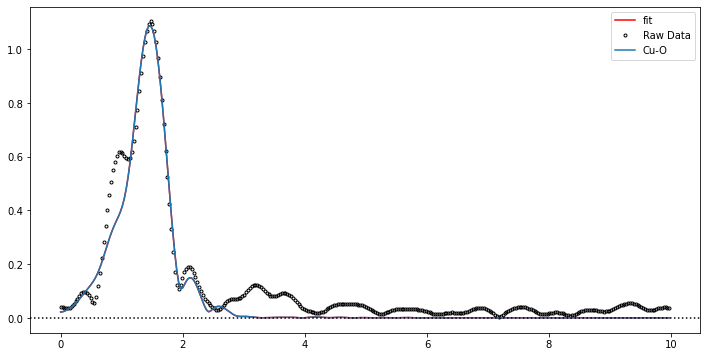

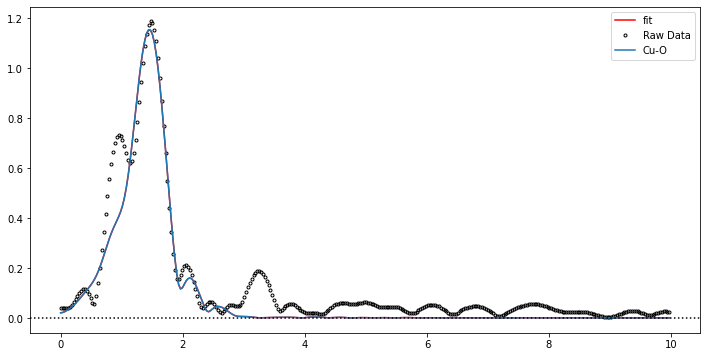

In [39]:
""" Misc: Plotting fitted results"""
for i, result in enumerate(_feffit_result.datasets):

    data_r = result.data.r
    data_chir_mag = result.data.chir_mag

    fit_r = result.model.r
    fit_chir_mag = result.model.chir_mag

#     a = result.paths["Cu256_" + str(i)].r
#     b = result.paths["Cu256_" + str(i)].chir_mag

    c = result.paths["O195_" + str(i)].r
    d = result.paths["O195_" + str(i)].chir_mag

    fig = plt.figure(figsize=(12, 6))
    plt.plot(fit_r, fit_chir_mag, color="r", label="fit")
    plt.plot(data_r, data_chir_mag, lw=0, marker='o', markersize=3, fillstyle='none', color="k", label="Raw Data")
#     plt.plot(a, b, label="Cu-Cu")
    plt.plot(c, d, label="Cu-O")
    plt.axhline(0, color="k", linestyle=":")
    plt.legend()

In [45]:
""" Misc: Print fitted results. """
print(feffit_report(_feffit_result))

=================== FEFFIT RESULTS ====================
[[Statistics]]
   nvarys, npts       =  22, 1960
   n_independent      =  143.690
   chi_square         =  412.003625
   reduced chi_square =  3.38567762
   r-factor           =  0.03443677
   Akaike info crit   =  195.359311
   Bayesian info crit =  260.647814
 
[[Datasets (10)]]
 dataset 1:
   fit space          = 'r'
   r-range            = 1.000, 4.000
   k-range            = 3.000, 10.000
   k window, dk       = 'hanning', 1.000
   paths used in fit  = ['C:/Users/user/larch/feff/Cu1_K_Tenorite_cif11639/feff0001.dat']
   k-weight           = 2
   epsilon_k          = Array(mean=0.00412981, std=0.00557741)
   epsilon_r          = 0.03679564
   n_independent      = 14.369
 dataset 2:
   fit space          = 'r'
   r-range            = 1.000, 4.000
   k-range            = 3.000, 10.000
   k window, dk       = 'hanning', 1.000
   paths used in fit  = ['C:/Users/user/larch/feff/Cu1_K_Tenorite_cif11639/feff0001.dat']
   k-weight    

In [40]:
""" Misc: Print fitted results. """
print(feffit_report(_feffit_result))

=================== FEFFIT RESULTS ====================
[[Statistics]]
   nvarys, npts       =  22, 1960
   n_independent      =  143.690
   chi_square         =  492.691586
   reduced chi_square =  4.04873835
   r-factor           =  0.04198771
   Akaike info crit   =  221.058473
   Bayesian info crit =  286.346977
 
[[Datasets (10)]]
 dataset 1:
   fit space          = 'r'
   r-range            = 1.000, 4.000
   k-range            = 3.000, 10.000
   k window, dk       = 'hanning', 3.000
   paths used in fit  = ['C:/Users/user/larch/feff/Cu1_K_Tenorite_cif11639/feff0001.dat']
   k-weight           = 2
   epsilon_k          = Array(mean=0.00405697, std=0.00559839)
   epsilon_r          = 0.03614665
   n_independent      = 14.369
 dataset 2:
   fit space          = 'r'
   r-range            = 1.000, 4.000
   k-range            = 3.000, 10.000
   k window, dk       = 'hanning', 3.000
   paths used in fit  = ['C:/Users/user/larch/feff/Cu1_K_Tenorite_cif11639/feff0001.dat']
   k-weight    

In [ ]:
""" Misc: Extract fitted parameters. """
s02 = _feffit_result.paramgroup.s02
e0 = _feffit_result.paramgroup.e0
delr_Cu256 = _feffit_result.paramgroup.delr_Cu256
sigma2_Cu256 = _feffit_result.paramgroup.sigma2_Cu256

_feffit_result.datasets